In [1]:
import torch
import torch.nn as nn
import math
torch.__version__

'2.7.1+cu128'

# Input Embedding

In [2]:
class InputEmbedding(nn.Module):
    def __init__(self , d_model: int , vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size , d_model)
    def forward(self,x):
        return self.embedding * math.sqrt(d_model)

# Positional Encoding

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self , d_model : int , seq_len: int , dropout : float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        #create a matrix of length (seqlen , d_model)
        pe = torch.zeroes(seq_len , d_model)
        position = torch.arrange(0, seq_len , dtype = torch.float).unsqueeze(1) #(seq_len , 1)
        div_term = torch.exp(torch.arange(0, d_model , 2).float() * (-math.log(10000.0) / d_model))
        #Apply sine to even position
        pe[:, 0::2] =torch.sin(position * div_term)
        #apply cosine to odd term
        pe[: , 1::2] = torch.cos(position *div_term)
        pe = pe.unsqueeze(0)# 1,seq_len , d_model
        self.register_buffer('pe' , pe)
    def forward(self  ,x):
        x=x + (self.pe[: , :x.shape[1] ,:]).requires_grad_(False)
        return self.dropout(x)

In [15]:
torch.randn(4,3).mean(1 , keepdim=True).shape

torch.Size([4, 1])

In [14]:
class LayerNormalization(nn.Module):
    def __init__(self, eps:float = 10 ** -6):
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1)) #Multiplied 
        self.bias = nn.Parameter(torch.zeros(1)) #Added
    def forward(self , x):
        mean = x.mean(dim= -1, keepdim = True)
        std = x.std(dim=-1 , keepdim=True)
        return self.alpha * ((x - mean)/(std + self.eps)) + self.bias
        

In [16]:
class FeedForwardBlock(nn.Module):
    def __init__(self , d_model:int ,d_ff:int , dropout:float )->None:
        super().__init__()
        self.linear1 = nn.Linear(d_model , d_ff) # W1 and b1 
        self.dropout = nn.Dropout(dropout)
        self.linear2= nn.Linear(d_ff , d_model) # W2 and b2
    def forward(self , x):
        # (batch , seq_len , d_model) --> (batch , seq_len , dff) --> (batch , seq_len , d_model)
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))

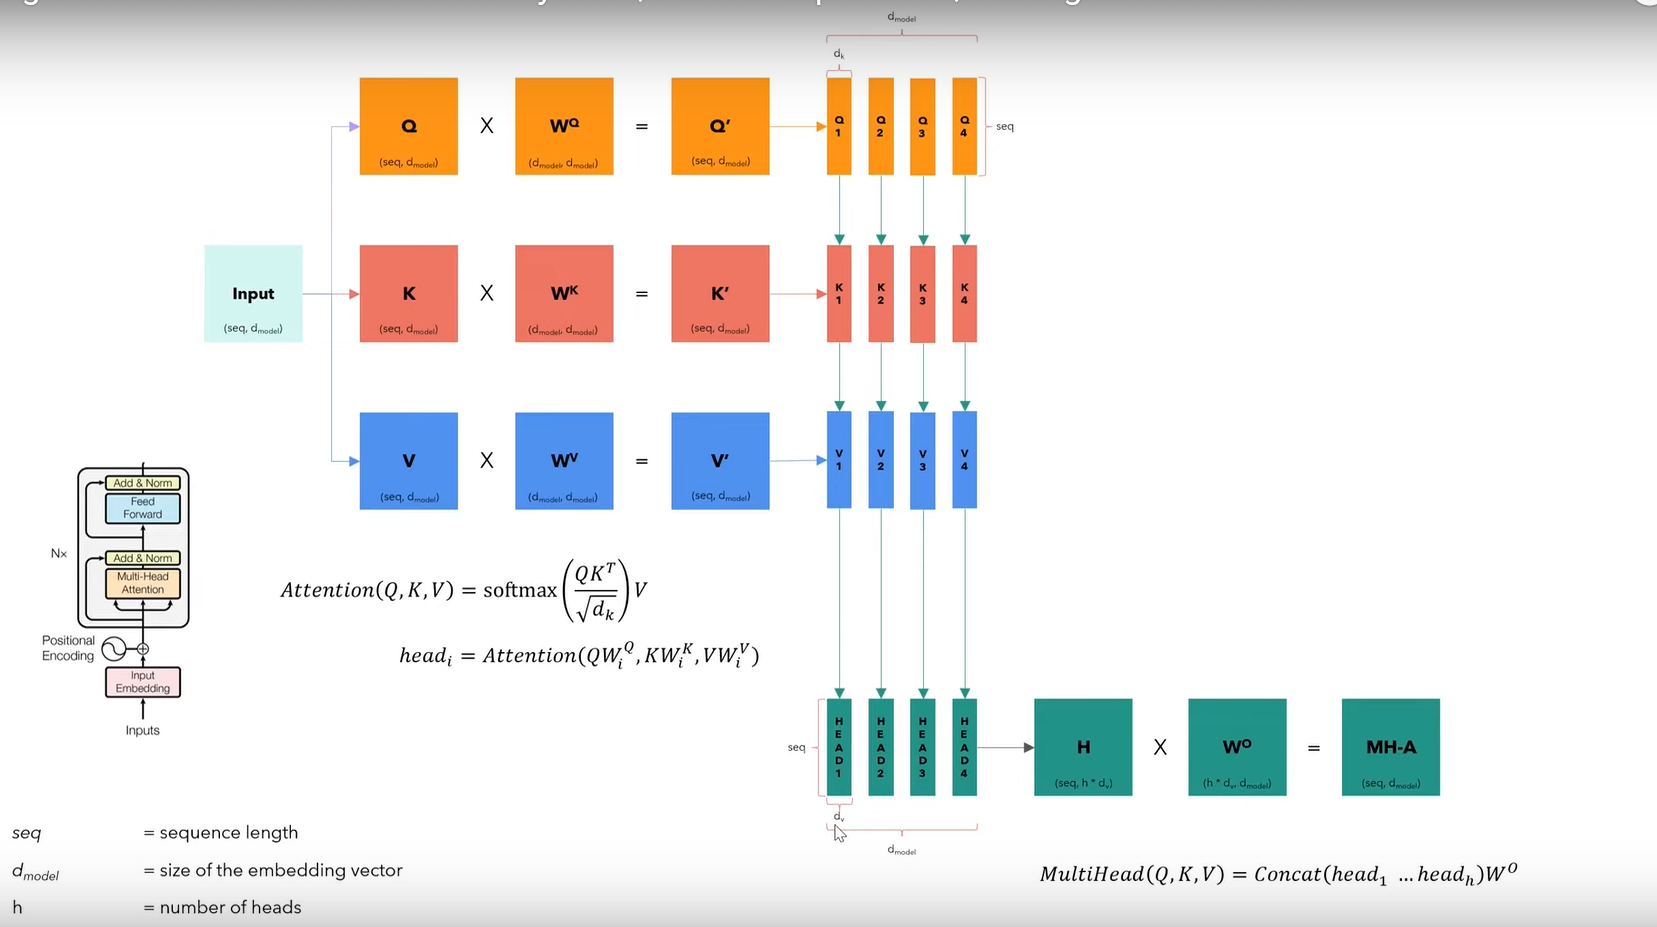

In [28]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model:int , h:int , dropout:float) -> None:
        super().__init__()
        self.d_model = d_model
        self.h= h
        assert d_model % h == 0 , "d_model is not divisible by h"
        self.d_k = d_model//h
        self.w_q = nn.Linear(d_model , d_model)# Wq
        self.w_k = nn.Linear(d_model , d_model)# Wk
        self.w_v = nn.Linear(d_model , d_model)# Wv
        
        self.w_0 = nn.Linear(d_model , d_model)# W0
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query , key , value , mask ,dropout : nn.Dropout):
        d_k = query.shape[-1]
        # (batch  , h , seq_len, d_k) --> (batch  , h , seq_len, seq_len)
        attention_score = (query @ key.transpose(-2,-1)) / math.sqrt(d_k)
        # before softmax apply mask
        if mask is not None:
            attention_score.masked_fill_(0 , -1e9)
        attention_score = attention_score.softmax(dim = -1)
        if dropout is not None:
            attention_score = dropout(attention_score)
        # (batch  , h , seq_len, seq_len) --> (batch  , h , seq_len, d_k) == [(attention_score @ value).shape]
        return (attention_score @ value) , attention_score
    def forward(self ,q,k,v,mask):
        query= self.w_q(q) #(batch , seq_len , d_model)
        key = self.q_k(k)#(batch , seq_len , d_model)
        value = self.w_v(v)#(batch , seq_len , d_model)

        #(batch , seq_len , d_model) --> (batch , seq_len , h, d_k) --> (batch  , h , seq_len, d_k)
        query = query.view(query.shape[0] , query.shape[1] , self.h , self.d_k).transpose(1,2)
        key = key.view(key.shape[0] , key.shape[1] , self.h , self.d_k).transpose(1,2)
        value = value.view(value.shape[0] , value.shape[1] , self.h , self.d_k).transpose(1,2)

        x, self.attention_score = MultiHeadAttentionBlock.attention(query , key ,value ,mask , self.dropout)
        # (batch  , h , seq_len, d_k) --> (batch  , seq_len , h, d_k) --> (batch  , seq_len , d_model)
        x= x.transpose(1,2).contiguous().view(x.shape[0] , -1 , self.h * self.d_k)
         # (batch  , seq_len , d_model)--> (batch  , seq_len , d_model)
        return self.w_0(x)
        

In [29]:
# (torch.randn(1,2,3,4) @ torch.randn(1,2,3,4).transpose(-2,-1)).shape # (1,2,3,3)

In [30]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout :float) ->None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()
    def forward(self, x , sublayer):
        return self.dropout(sublayer(self.norm(x)))

# Encoder

In [34]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block : MultiHeadAttentionBlock , feed_forward_block : FeedForwardBlock , dropout:float) ->None:
         super().__init__()
         self.self_attention_block = self_attention_block
         self.feed_forward_block = feed_forward_block
         self.dropout = nn.Dropout(dropout)
         self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])
    def forward(self , x , src_mask):
        x = self.residual_connections[0](x , lambda x : self.self_attention_block(x, x, x, src_mask))
        x= self.residual_connections[1](x , lambda x: self.feed_forward_block(x))
        return x
        

In [35]:
class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()
    def forward(self , x , mask):
        for layer in self.layers:
            x = layer(x , mask)
        return self.norm(x)